# mlos_bench SQLite data analysis (Teacher's copy)

In this notebook, we look at the data from 100 trials we ran in `mlos_bench` to find a better SQLite configuration.

### 1. Data collection

We used the following commands in the integrated terminal of this codespace:

```sh
conda activate mlos

mlos_bench --config config/cli/local-sqlite-opt.jsonc \
           --globals config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc \
           --trial-config-repeat-count 3 \
           --max-suggestions 100
```

> See Also: [README.md](./README.md) for further instructions.

Now we can start analyzing the autotuning data produced by running the benchmark trials.

### 2. Import MLOS packages

In [1]:
# Import mlos_bench Storage API to access the experimental data.
from mlos_bench.storage import from_config

### 3. Connect to the DB using existing mlos_bench configs

In [2]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 4. Load the data for our experiment

In [3]:
storage.experiments

{'sqlite-opt-demo': Experiment :: sqlite-opt-demo: 'SQLite3 BenchBase Local',
 'sqlite-opt-demo-default-sync': Experiment :: sqlite-opt-demo-default-sync: 'SQLite3 BenchBase Local'}

We see a record for our experiment in the DB. Let's look at the data associated with it.

In [4]:
experiment_id = "sqlite-opt-demo"

### 5. Get all data for one experiment

In [5]:
exp = storage.experiments[experiment_id]

In [6]:
# Display the set of optimization target objectives.
display(exp.objectives)

{'90th Percentile Latency (microseconds)': 'min'}

Main method that combines the information about each trial along with the trial configuration parameters and its results, is the property `.results`. It conveniently returns all data about the experiment is a single Pandas DataFrame.

In [7]:
# View some of the result data associated with that experiment.
df = exp.results_df
display(len(df))
df.head()

102

,trial_id,ts_start,ts_end,tunable_config_id,tunable_config_trial_group_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,...,result.Socket messages sent,result.Start timestamp (milliseconds),result.Swaps,result.System time (seconds),result.Throughput (requests/second),result.User time (seconds),result.Voluntary context switches,result.isolation,result.scalefactor,result.terminals
0,0,2024-01-18 22:02:13.841152+00:00,2024-01-18 22:02:28.876053+00:00,1,0,SUCCEEDED,1,delete,-1,-1,...,0,1705615337545,0,1.73,32.899683,5.59,122630,TRANSACTION_SERIALIZABLE,1,1
1,1,2024-01-18 22:02:28.894313+00:00,2024-01-18 22:02:41.965980+00:00,1,0,SUCCEEDED,1,delete,-1,-1,...,0,1705615350679,0,1.53,36.399678,4.38,124916,TRANSACTION_SERIALIZABLE,1,1
2,2,2024-01-18 22:02:41.980998+00:00,2024-01-18 22:02:55.135412+00:00,1,0,SUCCEEDED,1,delete,-1,-1,...,0,1705615363798,0,1.71,32.899946,4.55,118035,TRANSACTION_SERIALIZABLE,1,1
3,3,2024-01-18 22:02:55.166844+00:00,2024-01-18 22:03:08.341362+00:00,2,3,SUCCEEDED,1656398469,truncate,1633227268,363162755,...,0,1705615377016,0,1.61,163.398420,5.67,121895,TRANSACTION_SERIALIZABLE,1,1
4,4,2024-01-18 22:03:08.354700+00:00,2024-01-18 22:03:21.540316+00:00,2,3,SUCCEEDED,1656398469,truncate,1633227268,363162755,...,0,1705615390178,0,1.87,178.797832,5.71,122800,TRANSACTION_SERIALIZABLE,1,1


Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). The `trial_id` field is simply the iteration number within the current experiment. Let's look at the first record to see all these fields.

In [8]:
df.loc[1]

trial_id                                                                                              1
ts_start                                                               2024-01-18 22:02:28.894313+00:00
ts_end                                                                 2024-01-18 22:02:41.965980+00:00
tunable_config_id                                                                                     1
tunable_config_trial_group_id                                                                         0
status                                                                                        SUCCEEDED
config.cache_size                                                                                     1
config.journal_mode                                                                              delete
config.journal_size_limit                                                                            -1
config.mmap_size                                                

### 6. Visualize the results data automatically using `mlos_viz.plot()`

In [9]:
import mlos_viz

`mlos_viz` attempts to use the information about the data to automatically provide some basic visualizations without much effort on the developer's part.

At the moment, we do this using [`dabl`](https://github.com/dabl/dabl), though in the future we intend to add support for more interactive visualizations or even scheduling new trials, while maintaining a very simple API:

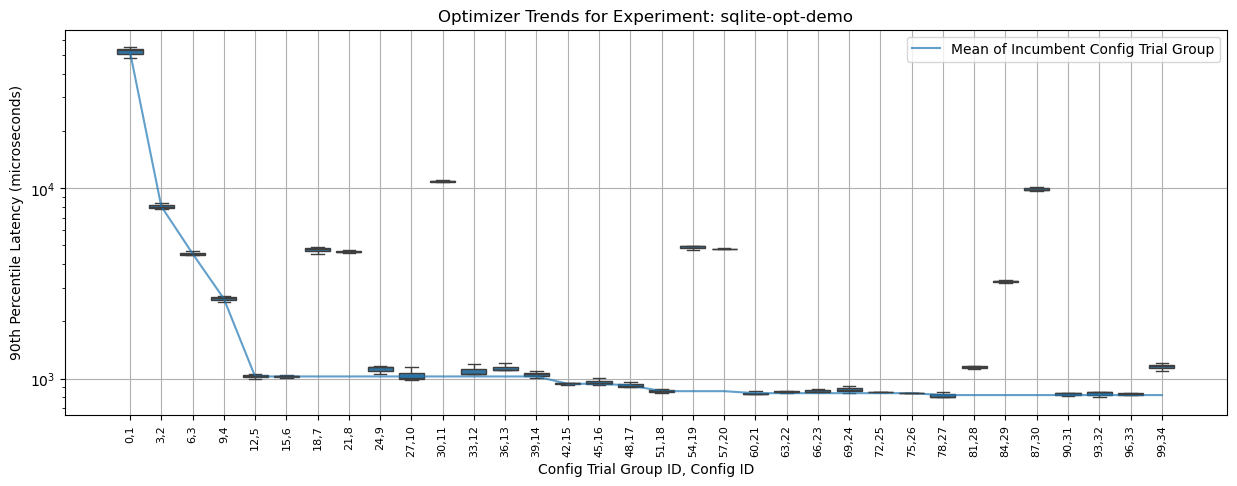

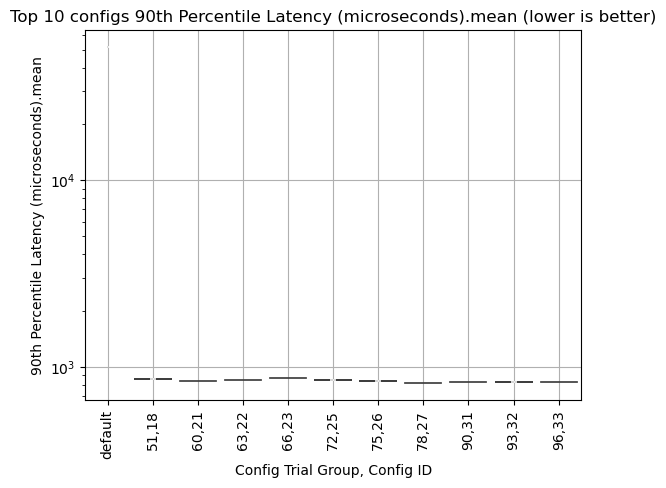

Target looks like regression


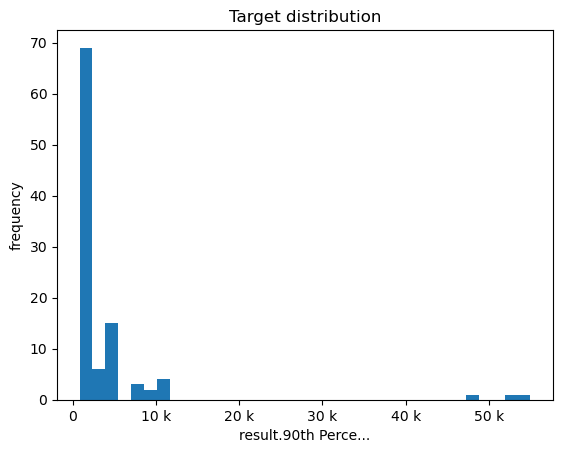

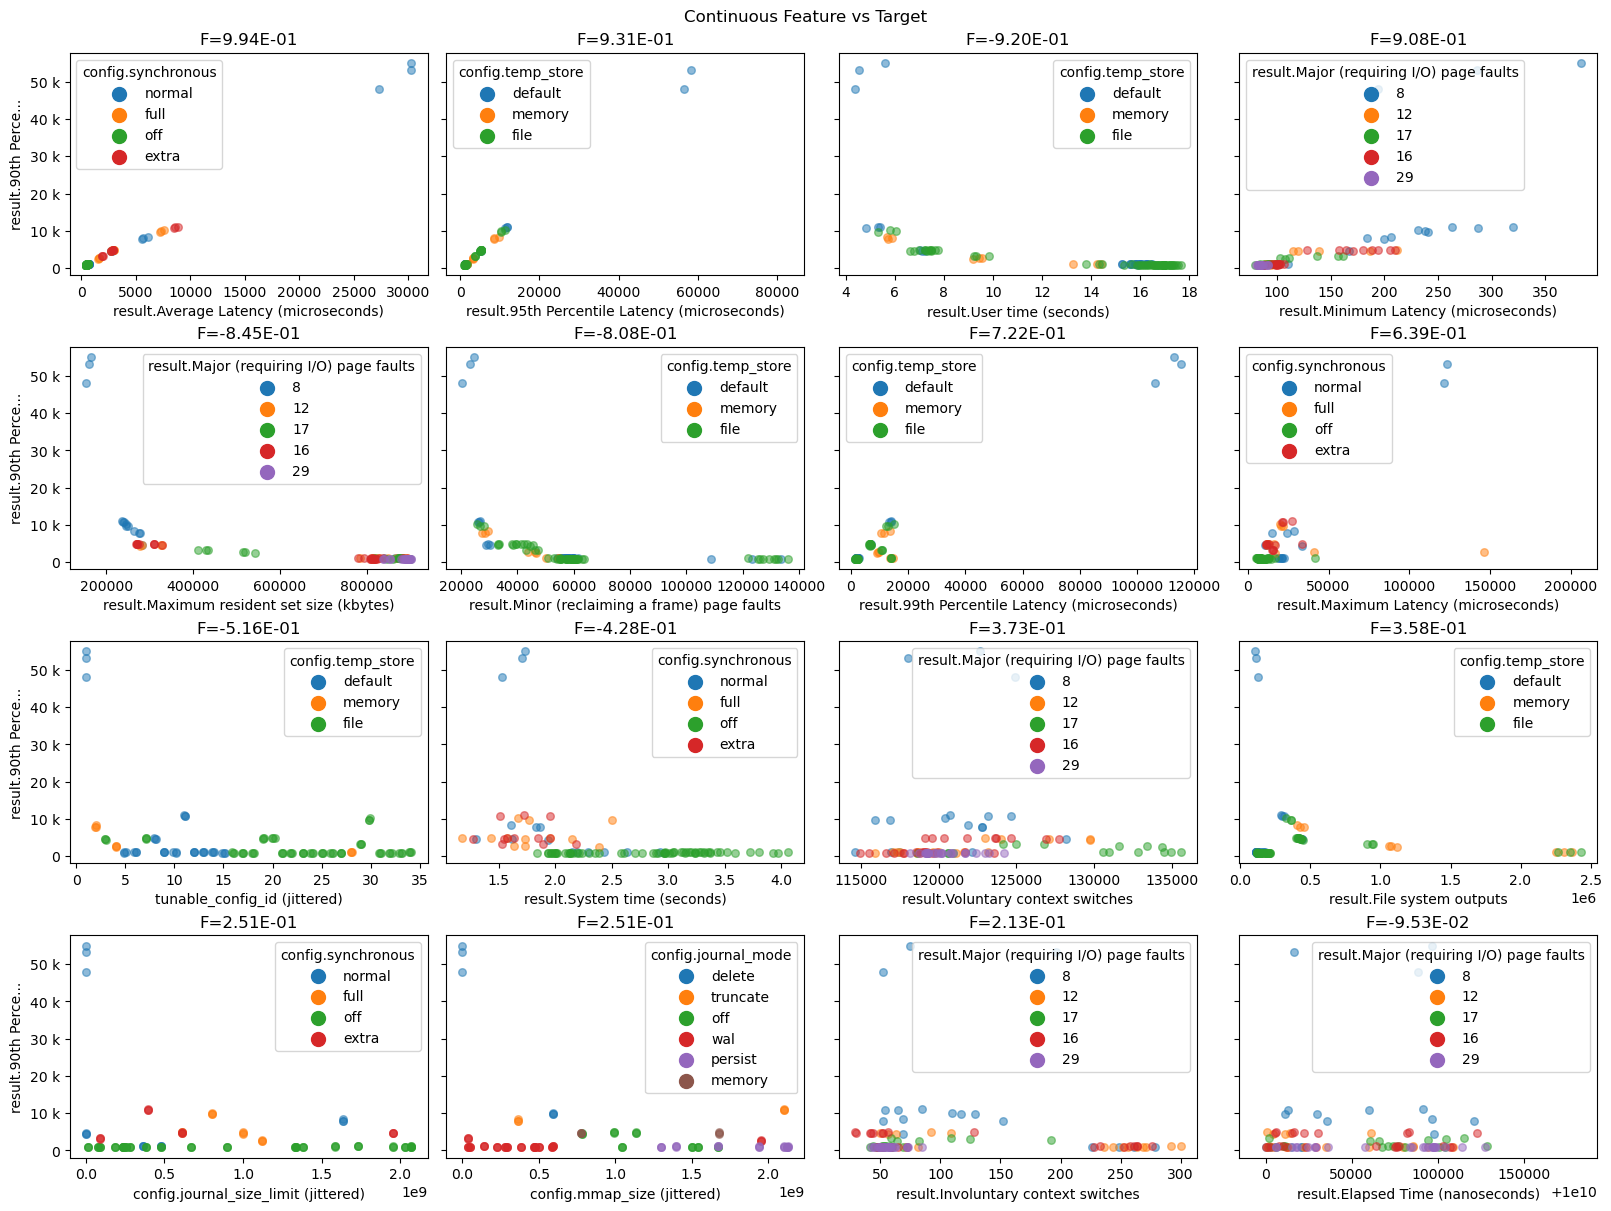

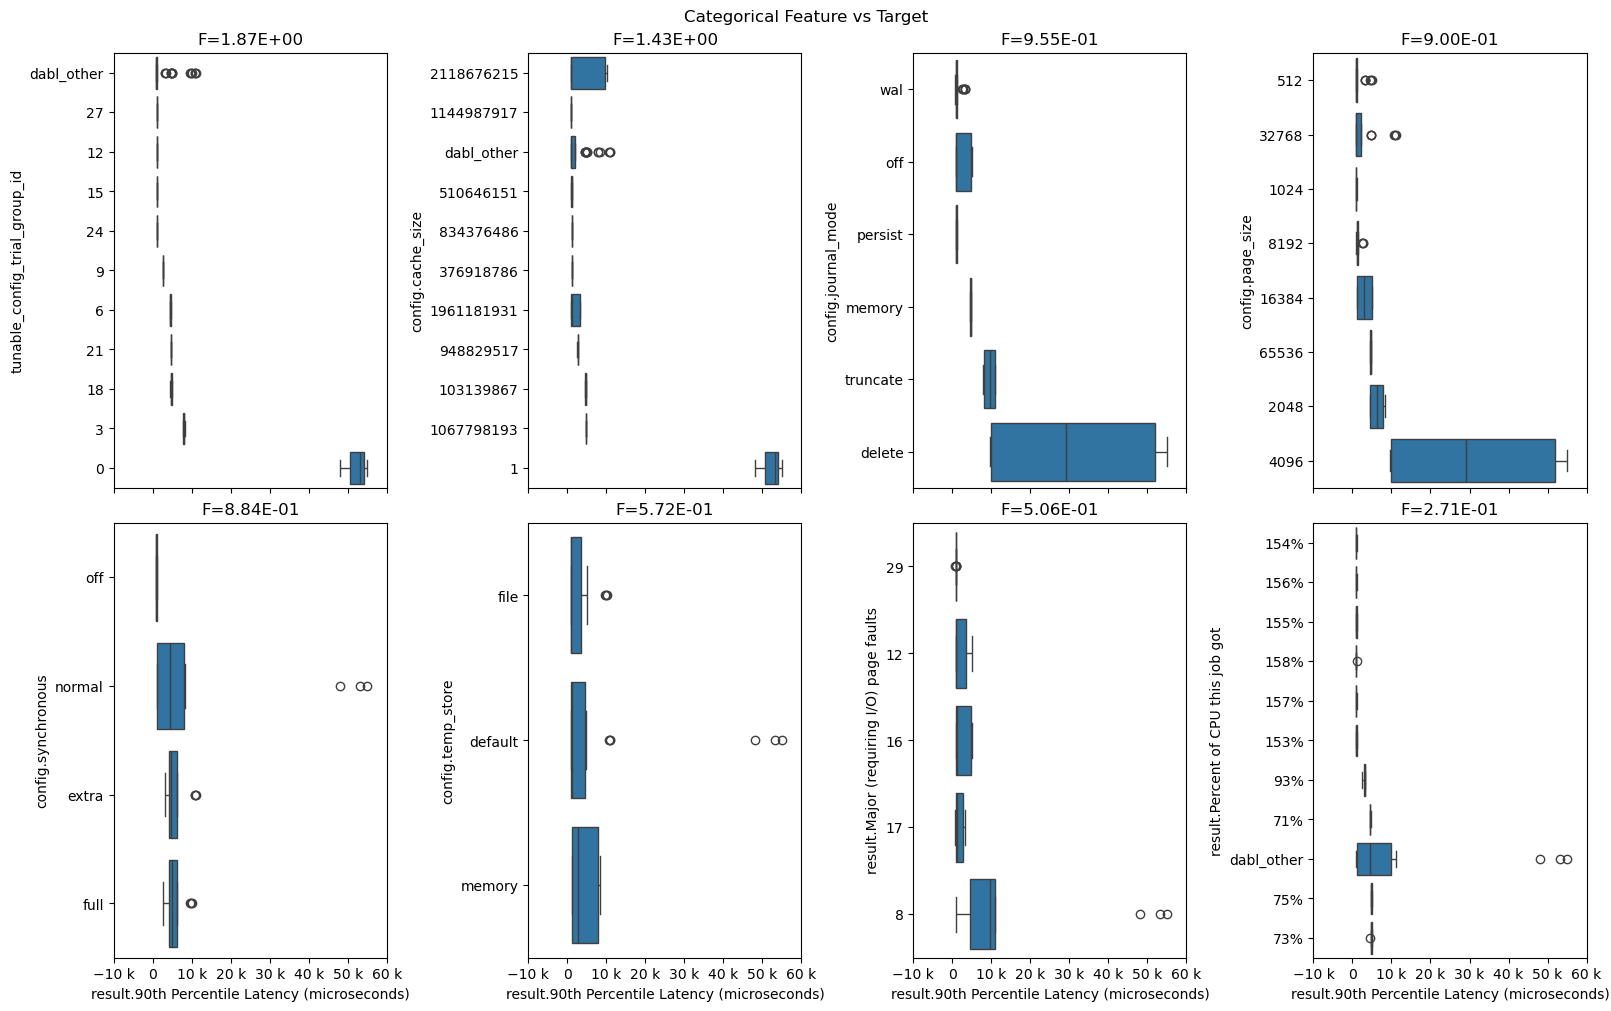

In [10]:
mlos_viz.plot(exp)

### 7. Refocusing on a new region of the config space

After examining the results visualized above, we can quickly see that the optimizer discovered that we're able to achieve lower objective metric (90th percentile latency) by disabling synchronous writes.

However, this may be a poor idea for some application scenarios where data durability is important.

Let's see if we can find a better configuration that still has synchronous writes enabled by adjusting our configurations to exclude that parameter from the search space.

We can rerun with a new experiment ID and prewarm the optimizer with trials that match this new configuration subspace.

```sh
# Rerun with a new config that has nosync disabled.
mlos_bench --config config/cli/local-sqlite-opt.jsonc \
           --globals config/experiments/sqlite-journal-pagesize-caching-experiment.jsonc \
           --trial-config-repeat-count 3 \
           --max-suggestions 100
# TODO: Extend with pre-warmer flag.
```

#### Reanalyze the new data

After that has run for a while we can reanalyze with the new data.

In [11]:
experiment_id_default_sync = "sqlite-opt-demo-default-sync"
exp_default_sync = storage.experiments[experiment_id_default_sync]

We could also use the `mlos_viz` package to visualize the results of the new experiment.

In [12]:
# mlos_viz.plot(exp_default_sync)

We can also use utility functions provided by `mlos_viz` to extract the top-N configs from the results, based on the original or a new objective metric.

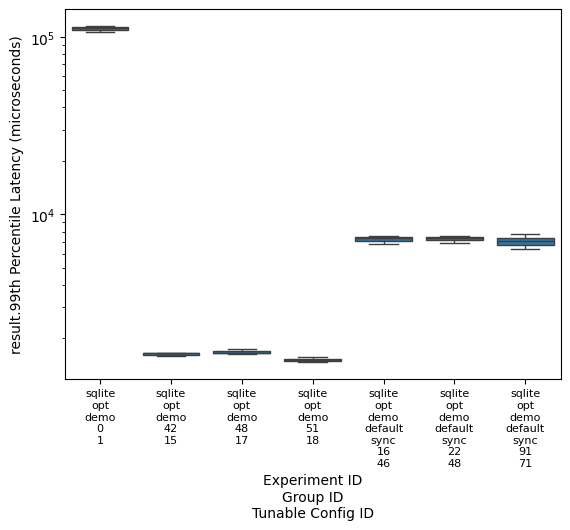

In [13]:
top_n = 3
alt_result_objectives = {"99th Percentile Latency (microseconds)": "min"}

# The limit_top_n_configs() API uses another API:
(top_n_configs_df, top_n_config_ids, orderby_cols) = mlos_viz.base.limit_top_n_configs(
    exp,
    top_n_configs=top_n,
    objectives=alt_result_objectives,
)
(top_n_configs_default_sync_df, top_n_config_ids_default_sync, orderby_cols) = mlos_viz.base.limit_top_n_configs(
    exp_default_sync,
    top_n_configs=top_n,
    objectives=alt_result_objectives,
)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas
from mlos_bench.storage.base_experiment_data import ExperimentData

def add_group_col(exp_id: str, df: pandas.DataFrame) -> pandas.DataFrame:
    group_col = "group_col"
    if group_col in df.columns:
        df = df.drop("group_col", axis=1)
    df[group_col] = df[["tunable_config_trial_group_id", "tunable_config_id"]].astype(str).apply(
        lambda x: "\n".join(exp_id.split("-")) + "\n" + "\n".join(x), axis=1)
    return df
add_group_col(exp.experiment_id, top_n_configs_df)
add_group_col(exp_default_sync.experiment_id, top_n_configs_default_sync_df)

combined_df = pandas.concat([
    top_n_configs_df,
    top_n_configs_default_sync_df.loc[top_n_configs_default_sync_df["tunable_config_id"] != exp_default_sync.default_tunable_config_id]])

sns.boxplot(
    data=combined_df,
    x="group_col",
    y=ExperimentData.RESULT_COLUMN_PREFIX + next(iter(alt_result_objectives.keys())),
)
plt.xlabel("Experiment ID\nGroup ID\nTunable Config ID")
plt.xticks(fontsize=8)
#plt.ylim(bottom=0)
plt.yscale("log")

plt.show()


We can also use additional utility functions in the `mlos_viz` package to augment the results with additional statistics about each config trial group to perform a more detailed manual analysis.

In [15]:
from mlos_bench.storage.base_experiment_data import ExperimentData
df = mlos_viz.base.augment_results_df_with_config_trial_group_stats(exp_default_sync)
cols = ["trial_id", "tunable_config_id", "tunable_config_trial_group_id", "status"]
cols += [col for col in df.columns
         if col.startswith(ExperimentData.RESULT_COLUMN_PREFIX)
         and any(obj in col for obj in alt_result_objectives)]
display(df[cols].head(10))

,trial_id,tunable_config_id,tunable_config_trial_group_id,status,result.99th Percentile Latency (microseconds),result.99th Percentile Latency (microseconds).mean,result.99th Percentile Latency (microseconds).var,result.99th Percentile Latency (microseconds).stddev,result.99th Percentile Latency (microseconds).var_zscore,result.99th Percentile Latency (microseconds).p50,result.99th Percentile Latency (microseconds).p75,result.99th Percentile Latency (microseconds).p90,result.99th Percentile Latency (microseconds).p95,result.99th Percentile Latency (microseconds).p99
0,1,35,1,SUCCEEDED,169812,174270.666667,1.814746e+08,13471.251513,5.643852,169812.0,179609.0,185487.2,187446.6,189014.12
1,2,35,1,SUCCEEDED,189406,174270.666667,1.814746e+08,13471.251513,5.643852,169812.0,179609.0,185487.2,187446.6,189014.12
2,3,35,1,SUCCEEDED,163594,174270.666667,1.814746e+08,13471.251513,5.643852,169812.0,179609.0,185487.2,187446.6,189014.12
3,4,36,4,SUCCEEDED,13944,15799.000000,2.580901e+06,1606.518285,-0.113705,16715.0,16726.5,16733.4,16735.7,16737.54
4,5,36,4,SUCCEEDED,16715,15799.000000,2.580901e+06,1606.518285,-0.113705,16715.0,16726.5,16733.4,16735.7,16737.54
5,6,36,4,SUCCEEDED,16738,15799.000000,2.580901e+06,1606.518285,-0.113705,16715.0,16726.5,16733.4,16735.7,16737.54
6,7,37,7,SUCCEEDED,10634,10154.000000,1.750090e+05,418.340770,-0.191137,9961.0,10297.5,10499.4,10566.7,10620.54
7,8,37,7,SUCCEEDED,9867,10154.000000,1.750090e+05,418.340770,-0.191137,9961.0,10297.5,10499.4,10566.7,10620.54
8,9,37,7,SUCCEEDED,9961,10154.000000,1.750090e+05,418.340770,-0.191137,9961.0,10297.5,10499.4,10566.7,10620.54
9,10,38,10,SUCCEEDED,15515,15194.333333,2.997801e+06,1731.415991,-0.100287,15515.0,16129.0,16497.4,16620.2,16718.44


### 8. Outro

If you feel curious, please go ahead and play with the SQLite data in the cells below.

After that, please open other notebooks in this repository and explore the data you have collected in this class as well as the results from our MySQL optimization experiments:

* [**mlos_demo_sqlite.ipynb**](mlos_demo_sqlite.ipynb) - Use this notebook to analyze the data you've collected during this workshop.
* [**mlos_demo_mysql.ipynb**](mlos_demo_mysql.ipynb) - Look at the actual production data we've collected in serveral experiment for MySQL Server optimization on Azure.